In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as trans

""" 基本參數"""
batch = 64

""" 取得數據集以及DataLoader """
transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize((0.5,),(0.5,)),
])

train_set = dset.MNIST(root='./mnist_data/', 
                       train=True, transform=transform, 
                       download=True)

test_set = dset.MNIST(root='./mnist_data/',
                      train=False, 
                      transform=transform, 
                      download=False)

train_loader = torch.utils.data.DataLoader(
    dataset = train_set,
    batch_size = batch,
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_set,
    batch_size = batch,
    shuffle=False        
)


torch.Size([1, 28, 28])
torch.Size([64]) tensor([8, 0, 4, 4, 3, 3, 6, 7, 3, 1, 7, 8, 0, 7, 8, 3, 3, 0, 0, 5, 1, 0, 9, 8,
        6, 0, 4, 0, 5, 0, 4, 6, 8, 7, 3, 7, 3, 2, 8, 3, 4, 6, 4, 4, 5, 3, 1, 5,
        0, 0, 7, 5, 0, 7, 8, 5, 9, 9, 8, 4, 3, 3, 1, 9])


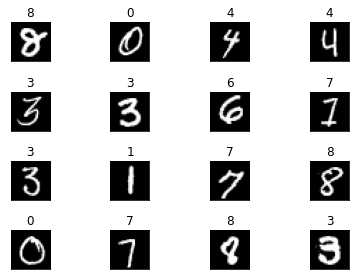

In [2]:
import matplotlib.pyplot as plt


for idx, (data, label) in enumerate(train_loader):
    
    if idx>0:break
        
    print(data[0].shape)
    print(label.shape, label)
    
    for i in range(16):
        im = data[i]
        plt.subplot(4,4,i+1)
        plt.title(label[i].numpy()), plt.xticks([]), plt.yticks([])
        plt.imshow( im.numpy().squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

# 建構生成器與鑑別器

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary

class Discriminator(nn.Module):
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            
            # Input size = 1 ,28 , 28
            nn.Conv2d(1, 64, (4,4), 2, 1),
            nn.LeakyReLU(),

            # Image size = (28-4+2)/2 +1 = 14
            nn.Conv2d(64,128, 4, 2, 1),
            nn.LeakyReLU(),
            
            # Image size = (14-4+2)/2 +1 = 7
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.LeakyReLU(),
            
            # Image size = (7-3+2)/2 +1 = 4
            nn.Conv2d(256, 1, 4, 2, 0),
            nn.Sigmoid(),
            
            # Image size = (4-4)/2 +1 = 1
        )
        
    def forward(self, x):
        
        return self.main(x)
    
D = Discriminator().to('cuda')
summary(D, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,088
         LeakyReLU-2           [-1, 64, 14, 14]               0
            Conv2d-3            [-1, 128, 7, 7]         131,200
         LeakyReLU-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 256, 4, 4]         295,168
         LeakyReLU-6            [-1, 256, 4, 4]               0
            Conv2d-7              [-1, 1, 1, 1]           4,097
           Sigmoid-8              [-1, 1, 1, 1]               0
Total params: 431,553
Trainable params: 431,553
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 1.65
Estimated Total Size (MB): 2.00
----------------------------------------------------------------


In [3]:
class Generator(nn.Module):
    
    def __init__(self, z_dim):

        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # image size =  (1-1)*1 - 2*0 + 4 = 4
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
             # image size =  (4-1)*2 - 2*1 + 4 = 8
            
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # image size =  (8-1)*2 - 2*1 + 4 = 16
            
            nn.ConvTranspose2d( 64, 1, 4, 2, 3, bias=False),
            nn.Tanh()
            # image size =  (16-1)*2 - 2*3 + 4 = 28
        )

    def forward(self, x):
        
        return self.main(x)
    
G = Generator(100).to('cuda')
summary(G, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,024
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 1,066,880
Trainable params: 1,066,880
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

# 訓練GAN

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import torch
import torchvision.datasets as dset
import torchvision.transforms as trans
import time

""" 基本參數 """
epoch = 10
lr = 1e-5
batch = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
z_dim = 100


""" 取得數據集以及DataLoader """
transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize((0.5,),(0.5,)),
])

train_set = dset.MNIST(root='./mnist_data/', 
                       train=True, transform=transform, 
                       download=True)

test_set = dset.MNIST(root='./mnist_data/',
                      train=False, 
                      transform=transform, 
                      download=False)

train_loader = torch.utils.data.DataLoader(
    dataset = train_set,
    batch_size = batch,
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_set,
    batch_size = batch,
    shuffle=False        
)

""" 訓練相關 """

D = Discriminator().to(device)
G = Generator(z_dim).to(device)
loss_fn = nn.BCELoss()
D_opt = optim.Adam(D.parameters(), lr= lr)
G_opt = optim.Adam(G.parameters(), lr= lr)
D_loss = []
G_loss = []
img = []
ls_time = []

for i in range(epoch):
    
    start_time = time.time()

    for idx, (data, _) in enumerate(train_loader):
        
        """ 訓練 D """
    
        D_opt.zero_grad()

        x_real = data.to(device)
        y_real = torch.ones(batch, ).to(device)
        y_real_predict = D(x_real)
        d_real_loss = loss_fn(y_real_predict.view(-1), y_real)
        d_real_loss.backward()

        noise = torch.randn(batch, z_dim, 1, 1, device = device)
        x_fake = G(noise)
        y_fake = torch.zeros(batch, ).to(device)
        y_fake_predict = D(x_fake)
        d_fake_loss = loss_fn(y_fake_predict.view(-1), y_fake)
        d_fake_loss.backward()

        D_loss.append(d_fake_loss.item() + d_real_loss.item())
        D_opt.step()

        """ 訓練 G """

        G_opt.zero_grad()

        noise = torch.randn(batch, z_dim, 1, 1, device = device)
        x_fake = G(noise)
        y_fake = torch.ones(batch, ).to(device)
        y_fake_predict = D(x_fake)
        g_loss = loss_fn(y_fake_predict.view(-1), y_fake)
        g_loss.backward()

        G_loss.append(g_loss.item())
        G_opt.step()
        
        if idx%100==0:
            with torch.no_grad():
                print("[{}/{}] \t D_LOSS:{:.6} \t G_LOSS:{:.6}".format(i+1, epoch, D_loss[idx], G_loss[idx]))
                noise = torch.randn(batch, z_dim, 1, 1, device = device)
                fake = G(noise)
                
                img.append(make_grid(fake, padding=0, normalize=True))
            
    end_time = time.time()
    cost_time = end_time - start_time
    ls_time.append(cost_time)
    print('Each Epoch Cost :{} s '.format(cost_time))

print('Total Cost Time : {}'.format(sum(ls_time)))

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!



[1/10] 	 D_LOSS:1.39217 	 G_LOSS:0.686381
[1/10] 	 D_LOSS:1.20732 	 G_LOSS:0.713619
[1/10] 	 D_LOSS:1.09292 	 G_LOSS:0.743566
[1/10] 	 D_LOSS:0.936623 	 G_LOSS:0.889129
[1/10] 	 D_LOSS:0.700947 	 G_LOSS:1.09723
[1/10] 	 D_LOSS:0.447683 	 G_LOSS:1.61929
[1/10] 	 D_LOSS:0.28416 	 G_LOSS:2.06139
[1/10] 	 D_LOSS:0.229903 	 G_LOSS:2.47553
[1/10] 	 D_LOSS:0.0535238 	 G_LOSS:3.52224
[1/10] 	 D_LOSS:0.0702399 	 G_LOSS:3.42511
[1/10] 	 D_LOSS:0.0184821 	 G_LOSS:4.47184
[1/10] 	 D_LOSS:0.00951174 	 G_LOSS:4.89439
[1/10] 	 D_LOSS:0.0261096 	 G_LOSS:3.95507
[1/10] 	 D_LOSS:0.100912 	 G_LOSS:4.59069
[1/10] 	 D_LOSS:0.0221243 	 G_LOSS:4.28103
[1/10] 	 D_LOSS:0.0353813 	 G_LOSS:3.90766
[1/10] 	 D_LOSS:0.0364875 	 G_LOSS:3.45949
[1/10] 	 D_LOSS:0.0151411 	 G_LOSS:4.23144
[1/10] 	 D_LOSS:0.0109279 	 G_LOSS:4.81636
[1/10] 	 D_LOSS:0.00899801 	 G_LOSS:5.06115
[1/10] 	 D_LOSS:0.00602012 	 G_LOSS:5.04562
[1/10] 	 D_LOSS:0.00

In [12]:
print('Generate Mnist Sample\n')
print('GPU \t{}'.format(torch.cuda.get_device_name(0)))
print('Epoch\t{}'.format(epoch))
print('Time\t{}s'.format(sum(ls_time)))

Generate Mnist Sample

GPU 	NVIDIA Tegra X1
Epoch	10
Time	10272.578087806702s


In [8]:
print(len(img))

1500


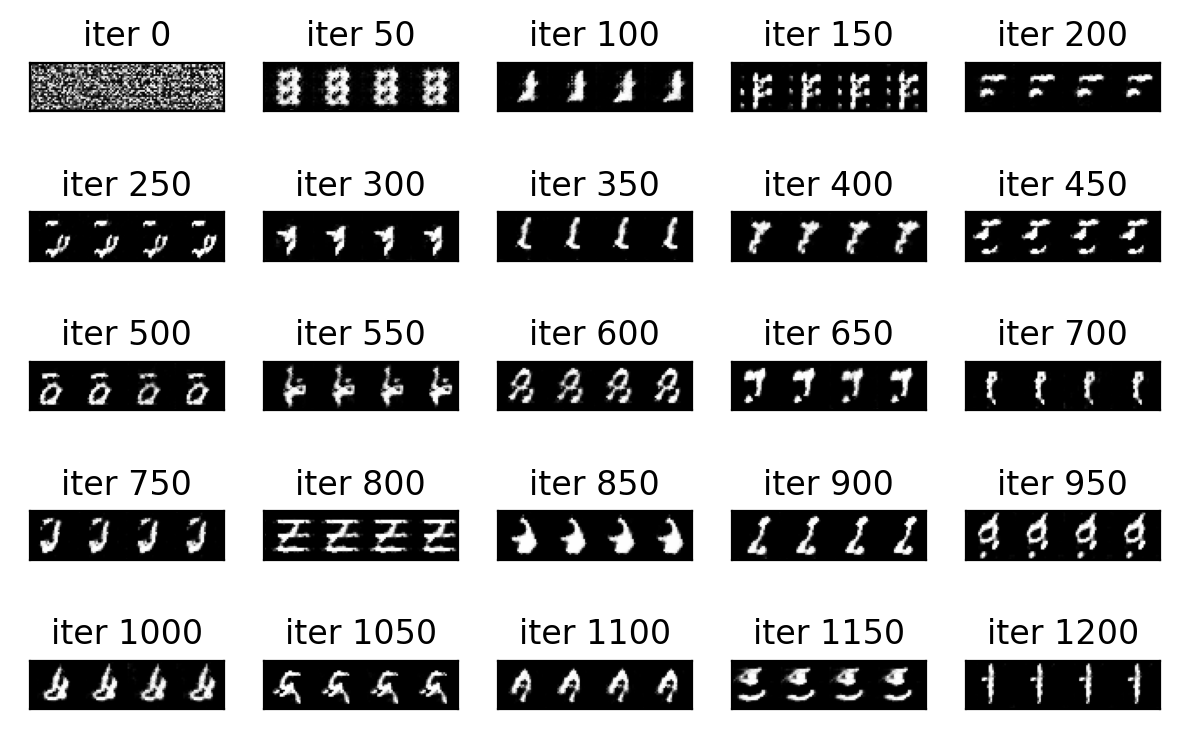

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
for i in range(25):
    plt.subplot(5,5,i+1)
    im = img[i*50].cpu().detach().numpy().transpose(1,2,0)
    plt.title('iter {}'.format(i*50) )
    plt.imshow(im)
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.show()